In [1]:
import sys 
import os

# Add the parent directory to the path if it's not already there
if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from ddql_optimal_execution import DDQL, MarketEnvironnement, Trainer, TWAP
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [72]:
QV = True
Volume = False

In [73]:
env = MarketEnvironnement(initial_inventory=500, multi_episodes=True, QV=QV, Volume=Volume, data_path='../data/train')

In [74]:
agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon)

Using cpu device


In [75]:
trainer = Trainer(agent, env, capacity=10000)

In [76]:
trainer.fill_exp_replay(max_steps=10000)

Filling experience replay buffer:   1%|          | 86/10000 [00:01<02:10, 75.78it/s]

In [ ]:
trainer.pretrain(max_steps=100, batch_size=128)

Pretraining agent: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


In [ ]:
trainer.agent.greediness = 0.9

In [ ]:
trainer.train(max_steps=1000, batch_size=128)

Training agent: 100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


In [ ]:
#test the agent
pnl= {'twap':[], 'ddql':[]}
test_env = MarketEnvironnement(initial_inventory=500, multi_episodes=True, QV=QV, Volume=Volume, data_path='../data/test')

twap = TWAP(initial_budget=test_env.initial_inventory, horizon=test_env.horizon)

pnl_twap = []
pnl_ddql = []


n_episodes = min(len(test_env.historical_data_series), 100)

random_ep = np.random.choice(np.arange(n_episodes), size=100, replace=True)

for ep in random_ep:
    test_env.swap_episode(ep)
    _pnl_twap = [0]
    while not test_env.done:
        current_state = test_env.state.copy()
        action = twap(current_state)
        _ = test_env.step(action)
        
    pnl_twap.append(test_env.pnl_for_episode + [test_env.state['Price']*test_env.state['inventory'] - test_env.quadratic_penalty_coefficient*(test_env.state['inventory']/test_env.initial_inventory)**2 / test_env.horizon])

    test_env.reset()
    
    _pnl_ddql = [0]
    while not test_env.done:
        current_state = test_env.state.copy()
        action = trainer.agent(current_state)
        _ = test_env.step(action)
    pnl_ddql.append(test_env.pnl_for_episode + [test_env.state['Price']*test_env.state['inventory'] - test_env.quadratic_penalty_coefficient*(test_env.state['inventory']/test_env.initial_inventory)**2 / test_env.horizon])

In [ ]:
pnl_ddql, pnl_twap = np.array(pnl_ddql), np.array(pnl_twap)

In [ ]:
pnl_ddql_sum = pnl_ddql.sum(axis=1)
pnl_twap_sum = pnl_twap.sum(axis=1)

delta_pnl = (pnl_ddql_sum - pnl_twap_sum)/ pnl_twap_sum



GLR = - delta_pnl[delta_pnl > 0].mean()/  delta_pnl[delta_pnl < 0].mean()

prob_win = np.bincount(delta_pnl > 0)[1] / len(delta_pnl)


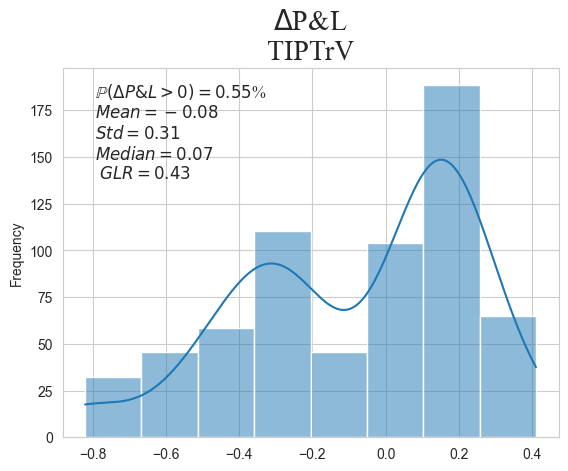

In [ ]:


sns.histplot(delta_pnl, kde=True, stat='frequency')
#change font$

title = "\n".join([r'$\Delta$P&L', 'TIPTr' + 'V'*Volume+'QV'*QV])
plt.title(title, fontdict={'fontfamily': 'times new roman'}, x=0.5, y=1, fontsize=20)
x, y = plt.xlim()[0]*.9, plt.ylim()[1] * .7
plt.text(x=x, y=y, s="\n".join([r'$\mathbb{P}(\Delta{P&L}'+r'>0 ) = {:.2f}$%'.format(prob_win) , 
            r'$Mean = {:.2f}$'.format(delta_pnl.mean()), r'$Std = {:.2f}$'.format(delta_pnl.std()), r'$Median = {:.2f}$'.format(np.median(delta_pnl)), r' $GLR = {:.2f}$'.format(GLR)]), fontsize=12, fontdict={'fontfamily': 'times new roman'})

#save with ransparent background

plt.savefig(title.replace("\n", "_").replace("$", "").replace("\\", "").replace("&", "n") +'.png', dpi=300, bbox_inches='tight',transparent=True)

In [71]:
confidence_level = .95



plt.plot(pnls.mean(axis=0), label='ddql')
plt.fill_between(range(len(pnls.mean(axis=0))), pnls.mean(axis=0)-confidence_level*pnls.std(axis=0)/np.sqrt(len(pnls)), pnls.mean(axis=0)+confidence_level*pnls.std(axis=0)/np.sqrt(len(pnls)), alpha=.2)


#plt.fill_between(range(len(pnl_ddql.mean(axis=0))), pnl_ddql.mean(axis=0)-confidence_level*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), pnl_ddql.mean(axis=0)+confidence_level*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), alpha=.2)
#plt.plot(pnl_twap.mean(axis=0), label='twap')
#plt.fill_between(range(len(pnl_twap.mean(axis=0))), pnl_twap.mean(axis=0)-confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), pnl_twap.mean(axis=0)+confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), alpha=.2)
plt.legend()
plt.xticks(
    rotation=45, ticks=range(5), labels=[f"Period {i}" for i in range(5)]
)

plt.title(r'PnL using normalized prices (with 95% confidence interval)')
plt.ylabel('PnL')
plt.show()

NameError: name 'pnls' is not defined

Text(0.5, 0, 'PnL')

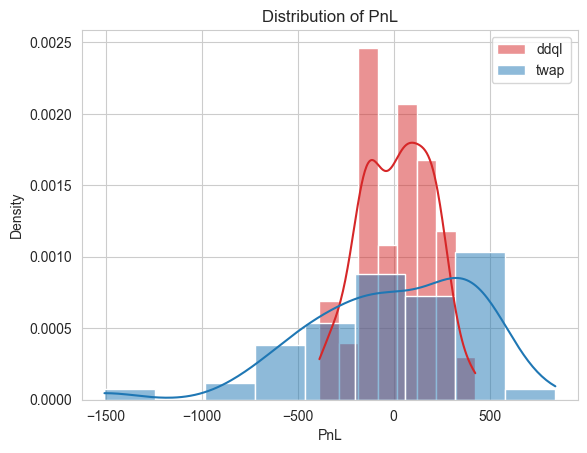

In [19]:
sns.histplot(pnl_twap.sum(axis=1), label='ddql', kde=True, stat='density', color='tab:red', alpha=.5)
sns.histplot(pnl_ddql.sum(axis=1), label='twap', kde=True, stat='density', color='tab:blue', alpha=.5)
plt.legend()
plt.title('Distribution of PnL')
plt.xlabel('PnL')

In [156]:
np.mean(pnl_twap.sum(axis=1))-np.mean(pnl_ddql.sum(axis=1))

-79.9967188603093

In [ ]:
grid = {
    "QV": [True, False],
    "Volume": [True, False],

}

data = dict()

for QV in grid["QV"]:
    for Volume in grid["Volume"]:
        env = MarketEnvironnement(initial_inventory=100, multi_episodes=True, QV=QV, Volume=Volume)
        agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon)
        trainer = Trainer(agent, env, capacity=10000)
        trainer.fill_exp_replay(max_steps=10000)
        trainer.pretrain(max_steps=1000, batch_size=32)
        trainer.train(max_steps=10000, batch_size=128)
        env.reset()
        twap = TWAP(initial_budget=env.initial_inventory, horizon=env.horizon)
        pnl_twap = []
        pnl_ddql = []
        random_ep = np.random.choice(np.arange(len(env.historical_data_series)), 100)
        for ep in random_ep:
            env.swap_episode(ep)
            _pnl_twap = [0]
            while not env.done:
                current_state = env.state.copy()
                action = twap(current_state)
                _ = env.step(action)
                _pnl_twap.append(env.state['Price']*action)
            pnl_twap.append(_pnl_twap)
            env.reset()
            _pnl_ddql = [0]
            while not env.done:
                current_state = env.state.copy()
                action = trainer.agent(current_state)
                _ = env.step(action)
                _pnl_ddql.append(env.state['Price']*action)
            pnl_ddql.append(_pnl_ddql)

        pnl_ddql, pnl_twap = np.array(pnl_ddql), np.array(pnl_twap)
        data[(QV, Volume)] = (pnl_ddql, pnl_twap)



In [159]:
import pickle

with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [169]:
sns.set_palette('pastel')
sns.set_style('whitegrid')

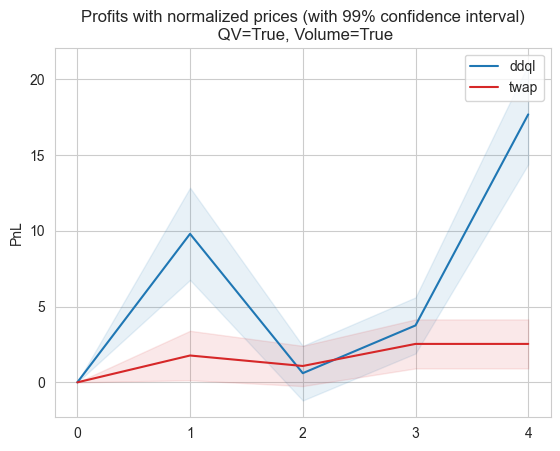

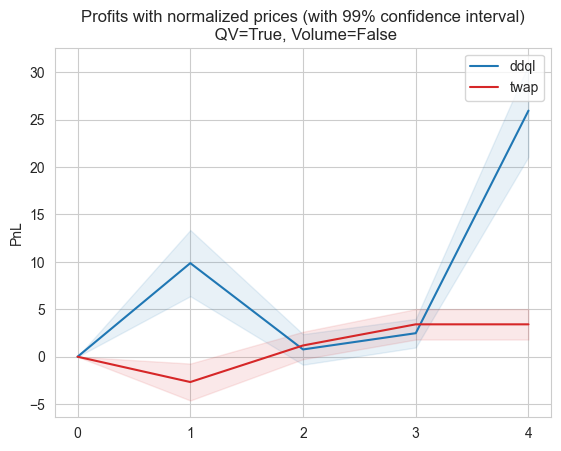

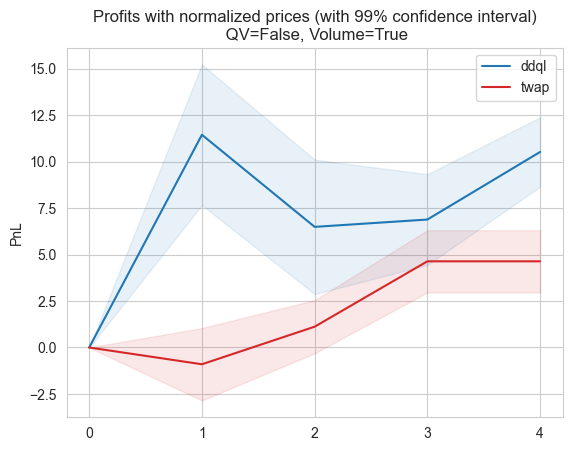

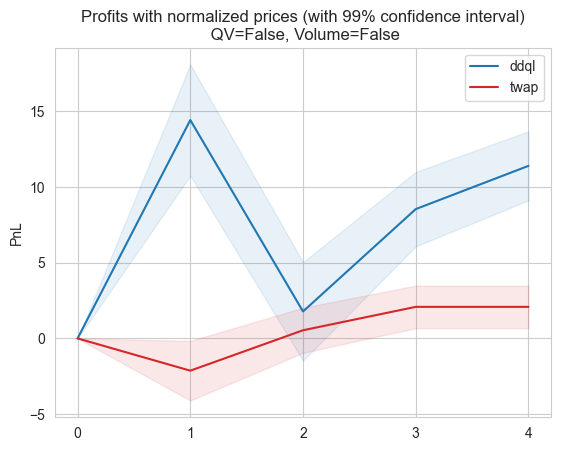

In [208]:
for i, (QV, Volume) in enumerate(data):
    pnl_ddql, pnl_twap = data[(QV, Volume)]
    
    confidence_level_2 = .99
    plt.plot(pnl_ddql.mean(axis=0), label='ddql', color='tab:blue')
    plt.fill_between(range(len(pnl_ddql.mean(axis=0))), pnl_ddql.mean(axis=0)-confidence_level_2*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), pnl_ddql.mean(axis=0)+confidence_level_2*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), alpha=.1,   color='tab:blue')

    plt.plot(pnl_twap.mean(axis=0), label='twap', color='tab:red')
    plt.fill_between(range(len(pnl_twap.mean(axis=0))), pnl_twap.mean(axis=0)-confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), pnl_twap.mean(axis=0)+confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), alpha=.1, color='tab:red')
    plt.legend()
    plt.xticks(
        #rotation=45,
        ticks=range(5), labels=[f"{i}" for i in range(5)]
    )
    plt.title(f'Profits with normalized prices (with 99% confidence interval)\n QV={QV}, Volume={Volume}')
    
    plt.ylabel('PnL')
    plt.savefig(f'pnl_QV_{QV}_Volume_{Volume}.png')
    plt.show()

(True, True) 23.906450396826592


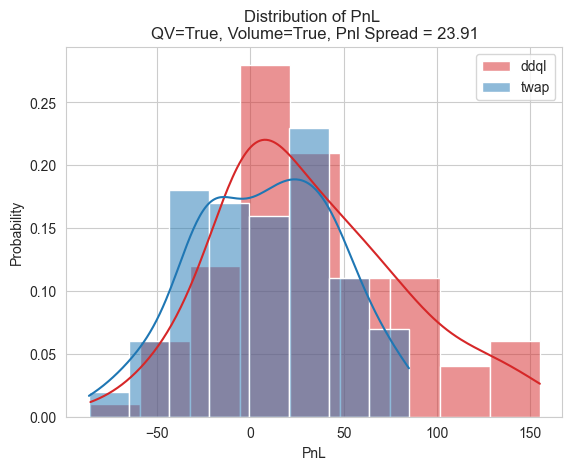

(True, False) 33.7180838651097


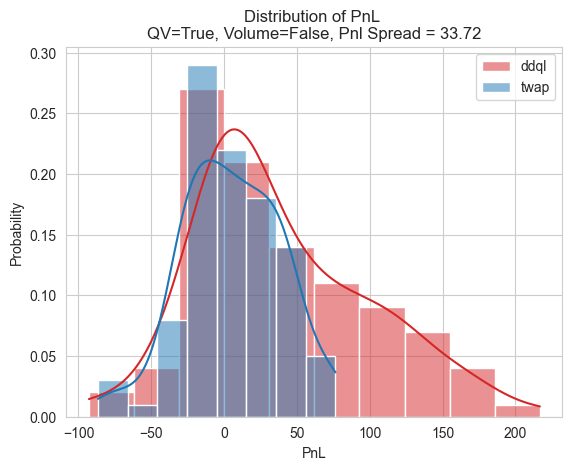

(False, True) 25.847956815623903


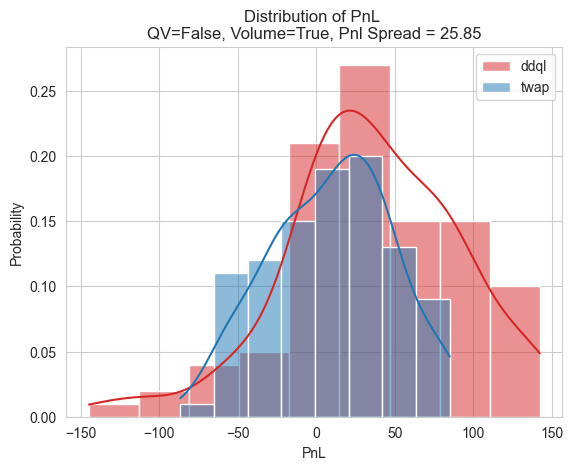

(False, False) 33.58937048445787


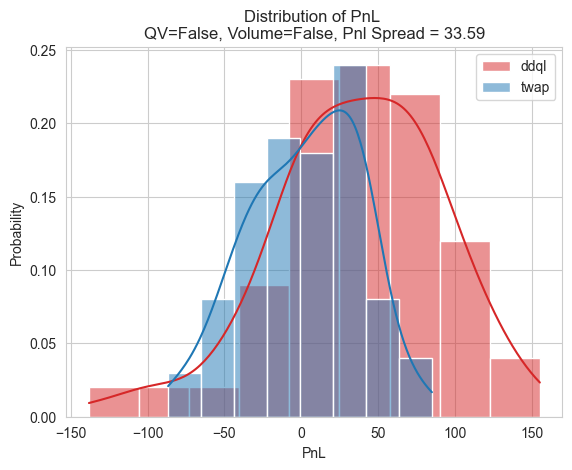

In [206]:
for key in data:
    print(key, np.mean(data[key][0].sum(axis=1))-np.mean(data[key][1].sum(axis=1)))
    #plt.hist(data[key][0].sum(axis=1), label='ddql', alpha=.5, color='tab:blue')
    #plt.axvline(np.mean(data[key][0].sum(axis=1)), color='tab:blue')
    #plt.hist(data[key][1].sum(axis=1), label='twap', alpha=.5, color='tab:red')
    #plt.axvline(np.mean(data[key][1].sum(axis=1)), color='tab:red')

    pnl_twap, pnl_ddql = data[key]

    sns.histplot(pnl_twap.sum(axis=1), label='ddql', kde=True, stat='probability', color='tab:red', alpha=.5)
    sns.histplot(pnl_ddql.sum(axis=1), label='twap', kde=True, stat='probability', color='tab:blue', alpha=.5)
    #plt.legend()
    #plt.title('')
    plt.xlabel('PnL')

    plt.legend()
    plt.title(f'Distribution of PnL \nQV={key[0]}, Volume={key[1]}, Pnl Spread = {np.mean(data[key][0].sum(axis=1))-np.mean(data[key][1].sum(axis=1)):.2f}')
    plt.savefig(f'../figs/QV_{key[0]}_Volume_{key[1]}_hists.png')
    plt.show()


In [203]:

# Draft Martial

import pandas as pd
import numpy as np

def fake_data(S : float = 100, r : float = 0.1, sigma : float = 0.2, start='2022-01-01 11:00:01', end='2022-01-01 13:00:00'):
    # Creation of the dataset output
    data = pd.DataFrame(pd.date_range(start=start, end=end,  freq = "s"), columns=['Date'])
    num_points, _ = np.shape(data)

    # Simulate a Black-Scholes trajectory
    dt = 1/252/6.5/3600 # scale of a second
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * np.random.normal(size=num_points - 1)
    log_returns = np.concatenate([[0], drift + diffusion])
    log_prices = np.cumsum(log_returns)
    prices = S * np.exp(log_prices)
    
    data["Price"] = prices
    data.set_index('Date', inplace=True)


    return data


In [7]:
for i in range(100):
    fake_data(start="2022-01-01 11:00:01", end="2022-01-01 12:00:00").to_csv(f"../data/fake_data_{i}.csv")
    fake_data(start="2022-01-01 12:00:01", end="2022-01-01 13:00:00").to_csv(f"../data/fake_data_{i+100}.csv")
    fake_data(start="2022-01-01 13:00:01", end="2022-01-01 14:00:00").to_csv(f"../data/fake_data_{i+200}.csv")